In [195]:
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Data processing

In [59]:
# load data
filepath = '/glade/work/psturm/ice-mp-su24/saved_trajectory_data/trajs_5100_7200_Ns10000.csv' # obin's latest csv with combined data
df = pd.read_csv(filepath)

# sort df
sort_cols = ['time', 'rk_deact']
df_sort = df.sort_values(by=sort_cols)

# print time and rk_deact columns as quick check
print(df_sort[sort_cols])

# do a check for a single timestep
df_5100 = df_sort[df_sort.time==5100]
print('Check for single timestep 5100s')
print(f'length of ID vector: {len(df_5100.rk_deact)}')
print(f'number of unique IDs: {len(df_5100.rk_deact.unique())}')

        time    rk_deact
4360    5100       13957
4361    5100      150328
4362    5100      206362
4363    5100      207674
4364    5100      218111
...      ...         ...
351068  7200  1015230609
351069  7200  1015266378
351070  7200  1015305678
349741  7200  1015329135
351024  7200  1015454933

[356976 rows x 2 columns]
Check for single timestep 5100s
length of ID vector: 9916
number of unique IDs: 9916


In [60]:
df_sort.columns

Index(['Unnamed: 0', 'rk_deact', 'x[m]', 'y[m]', 'z[m]', 'vz[m]',
       'radius(droplet)[m]', 'mass_of_aerosol_in_droplet/ice(1:01)[g]',
       'radius_eq(ice)[m]', 'radius_pol(ice)[m]',
       'density(droplet/ice)[kg/m3]', 'rhod [kg/m3]', 'multiplicity[-]',
       'status[-]', 'index', 'rime_mass[kg]', 'num_of_monomers[-]', 'time',
       'xi gridbox', 'yk gridbox', 'zh gridbox', 'time index', 'rh', 'th',
       'prs', 'qv', 'uinterp', 'vinterp', 'winterp', 'out8', 'out9', 'out10',
       'out11', 'out12', 'out13', 'out14', 'deactrat', 'T [K]', 'RH_ice',
       'RH_liquid', 'RH_diff'],
      dtype='object')

In [64]:
# calculate mass and add as column
df_sort['volume[m3]'] = (4/3)*np.pi*(df_sort['radius_eq(ice)[m]'])**3
df_sort['mass[kg]'] = df_sort['volume[m3]']*df_sort['density(droplet/ice)[kg/m3]']
df_sort[['radius_eq(ice)[m]', 'volume[m3]', 'mass[kg]']]

,radius_eq(ice)[m],volume[m3],mass[kg]
4360,0.000013,9.054558e-15,3.794836e-12
4361,0.000021,3.845164e-14,1.379069e-11
4362,0.000026,7.278837e-14,1.541835e-11
4363,0.000033,1.496556e-13,4.462700e-11
4364,0.000018,2.385564e-14,7.938225e-12
...,...,...,...
351068,0.000021,3.787968e-14,7.576020e-12
351069,0.000012,7.778861e-15,1.555800e-12
351070,0.000087,2.799120e-12,5.628925e-10
349741,0.000056,7.223066e-13,1.444621e-10


In [65]:
df1 = df_sort 
n_unique_ids = len(df1['rk_deact'].unique())
len_df = len(df1) - n_unique_ids
df1 = df_sort[:len_df]
df1.reset_index(inplace=True)
df1.shape

(347060, 44)

In [66]:
df2 = df_sort
df2 = df2[n_unique_ids:]
df2.reset_index(inplace=True)
df2.shape

(347060, 44)

In [67]:
# join dataframes
df = df1.join(df2, lsuffix='_1', rsuffix='_2')
df

,level_0_1,Unnamed: 0_1,rk_deact_1,x[m]_1,y[m]_1,z[m]_1,vz[m]_1,radius(droplet)[m]_1,mass_of_aerosol_in_droplet/ice(1:01)[g]_1,radius_eq(ice)[m]_1,...,out12_2,out13_2,out14_2,deactrat_2,T [K]_2,RH_ice_2,RH_liquid_2,RH_diff_2,volume[m3]_2,mass[kg]_2
0,4360,4360,13957,187.02308,131.37815,9362.9834,0.0,0.0,1.048439e-14,0.000013,...,336.595032,14.001214,14.001214,-6.621117e-09,232.110924,0.997001,0.664628,0.008388,8.598998e-15,3.603907e-12
1,4361,4361,150328,280.41348,123.98104,9479.3545,0.0,0.0,1.776257e-14,0.000021,...,354.739624,9.352058,9.352058,-2.457631e-09,231.159666,1.000650,0.660578,0.008478,3.841255e-14,1.376532e-11
2,4362,4362,206362,362.41535,226.61712,9679.0052,0.0,0.0,2.233854e-14,0.000026,...,302.004425,6.072549,6.072549,1.721107e-09,229.309070,1.003703,0.650070,0.008626,7.294642e-14,1.544887e-11
3,4363,4363,207674,433.96419,252.61293,9350.2859,0.0,0.0,2.910743e-13,0.000033,...,420.421875,7.234190,7.234190,8.823843e-09,232.071147,1.017993,0.678345,0.008563,1.566355e-13,4.600479e-11
4,4364,4364,218111,123.32099,369.23415,9486.0378,0.0,0.0,8.156556e-14,0.000018,...,320.557495,6.739596,6.739596,-2.079506e-09,231.189258,1.001454,0.661310,0.008486,2.371593e-14,7.891735e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347055,343778,343778,1015230609,11655.36400,11895.40400,9597.7637,0.0,0.0,1.902701e-14,0.000022,...,414.409027,13.616765,13.616765,-6.029041e-08,229.940011,0.983420,0.641098,0.008381,3.787968e-14,7.576020e-12
347056,343779,343779,1015266378,11743.64800,11799.43100,9758.7617,0.0,0.0,5.646258e-15,0.000013,...,385.077393,5.706291,5.706291,-3.655712e-08,228.075858,0.989389,0.632679,0.008552,7.778861e-15,1.555800e-12
347057,343780,343780,1015305678,11771.92800,11686.20800,8977.0945,0.0,0.0,1.904751e-13,0.000087,...,367.272278,0.015625,0.015625,1.539362e-09,235.261644,1.017356,0.700312,0.008286,2.799120e-12,5.628925e-10
347058,340080,340080,1015329135,11473.41500,11976.99200,9335.0350,0.0,0.0,8.063607e-14,0.000056,...,524.944641,19.641491,19.641491,7.995893e-09,231.851583,1.010303,0.671707,0.008491,7.223066e-13,1.444621e-10


In [68]:
df.columns

Index(['level_0_1', 'Unnamed: 0_1', 'rk_deact_1', 'x[m]_1', 'y[m]_1', 'z[m]_1',
       'vz[m]_1', 'radius(droplet)[m]_1',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_1', 'radius_eq(ice)[m]_1',
       'radius_pol(ice)[m]_1', 'density(droplet/ice)[kg/m3]_1',
       'rhod [kg/m3]_1', 'multiplicity[-]_1', 'status[-]_1', 'index_1',
       'rime_mass[kg]_1', 'num_of_monomers[-]_1', 'time_1', 'xi gridbox_1',
       'yk gridbox_1', 'zh gridbox_1', 'time index_1', 'rh_1', 'th_1', 'prs_1',
       'qv_1', 'uinterp_1', 'vinterp_1', 'winterp_1', 'out8_1', 'out9_1',
       'out10_1', 'out11_1', 'out12_1', 'out13_1', 'out14_1', 'deactrat_1',
       'T [K]_1', 'RH_ice_1', 'RH_liquid_1', 'RH_diff_1', 'volume[m3]_1',
       'mass[kg]_1', 'level_0_2', 'Unnamed: 0_2', 'rk_deact_2', 'x[m]_2',
       'y[m]_2', 'z[m]_2', 'vz[m]_2', 'radius(droplet)[m]_2',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_2', 'radius_eq(ice)[m]_2',
       'radius_pol(ice)[m]_2', 'density(droplet/ice)[kg/m3]_2',
       'rhod

In [69]:
df['rk_deact_1'].equals(df['rk_deact_2'])

True

In [70]:
cols = ['time_1', 'rk_deact_1', 'time_2', 'rk_deact_2']
test = df[cols]
test

,time_1,rk_deact_1,time_2,rk_deact_2
0,5100,13957,5160,13957
1,5100,150328,5160,150328
2,5100,206362,5160,206362
3,5100,207674,5160,207674
4,5100,218111,5160,218111
...,...,...,...,...
347055,7140,1015230609,7200,1015230609
347056,7140,1015266378,7200,1015266378
347057,7140,1015305678,7200,1015305678
347058,7140,1015329135,7200,1015329135


In [71]:
# split into training and test data
ids = df['rk_deact_1'].unique()
len(ids)

9916

In [72]:
ids_train, ids_test = train_test_split(ids, test_size=0.2, random_state=666)
print(len(ids_train), len(ids_test))

7932 1984


In [73]:
df_train = df[df['rk_deact_1'].isin(ids_train)]
df_test = df[df['rk_deact_1'].isin(ids_test)]

# Linear model

In [74]:
df_train.columns

Index(['level_0_1', 'Unnamed: 0_1', 'rk_deact_1', 'x[m]_1', 'y[m]_1', 'z[m]_1',
       'vz[m]_1', 'radius(droplet)[m]_1',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_1', 'radius_eq(ice)[m]_1',
       'radius_pol(ice)[m]_1', 'density(droplet/ice)[kg/m3]_1',
       'rhod [kg/m3]_1', 'multiplicity[-]_1', 'status[-]_1', 'index_1',
       'rime_mass[kg]_1', 'num_of_monomers[-]_1', 'time_1', 'xi gridbox_1',
       'yk gridbox_1', 'zh gridbox_1', 'time index_1', 'rh_1', 'th_1', 'prs_1',
       'qv_1', 'uinterp_1', 'vinterp_1', 'winterp_1', 'out8_1', 'out9_1',
       'out10_1', 'out11_1', 'out12_1', 'out13_1', 'out14_1', 'deactrat_1',
       'T [K]_1', 'RH_ice_1', 'RH_liquid_1', 'RH_diff_1', 'volume[m3]_1',
       'mass[kg]_1', 'level_0_2', 'Unnamed: 0_2', 'rk_deact_2', 'x[m]_2',
       'y[m]_2', 'z[m]_2', 'vz[m]_2', 'radius(droplet)[m]_2',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_2', 'radius_eq(ice)[m]_2',
       'radius_pol(ice)[m]_2', 'density(droplet/ice)[kg/m3]_2',
       'rhod

In [81]:
# train model and predict
model = linear_model.LinearRegression()
X_cols = ['RH_ice_1', 'mass[kg]_1']
y_cols = ['mass[kg]_2']
X_train = df_train[X_cols]
y_train = df_train[y_cols]
X_test = df_test[X_cols]
y_test = df_test[y_cols]
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [85]:
X_test.shape

(69440, 2)

In [86]:
y_test.shape

(69440, 1)

In [88]:
df_train.columns

Index(['level_0_1', 'Unnamed: 0_1', 'rk_deact_1', 'x[m]_1', 'y[m]_1', 'z[m]_1',
       'vz[m]_1', 'radius(droplet)[m]_1',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_1', 'radius_eq(ice)[m]_1',
       'radius_pol(ice)[m]_1', 'density(droplet/ice)[kg/m3]_1',
       'rhod [kg/m3]_1', 'multiplicity[-]_1', 'status[-]_1', 'index_1',
       'rime_mass[kg]_1', 'num_of_monomers[-]_1', 'time_1', 'xi gridbox_1',
       'yk gridbox_1', 'zh gridbox_1', 'time index_1', 'rh_1', 'th_1', 'prs_1',
       'qv_1', 'uinterp_1', 'vinterp_1', 'winterp_1', 'out8_1', 'out9_1',
       'out10_1', 'out11_1', 'out12_1', 'out13_1', 'out14_1', 'deactrat_1',
       'T [K]_1', 'RH_ice_1', 'RH_liquid_1', 'RH_diff_1', 'volume[m3]_1',
       'mass[kg]_1', 'level_0_2', 'Unnamed: 0_2', 'rk_deact_2', 'x[m]_2',
       'y[m]_2', 'z[m]_2', 'vz[m]_2', 'radius(droplet)[m]_2',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]_2', 'radius_eq(ice)[m]_2',
       'radius_pol(ice)[m]_2', 'density(droplet/ice)[kg/m3]_2',
       'rhod

/glade/derecho/scratch/joko/tmp/ipykernel_17083/3446523609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mass_diff']=df_train['mass[kg]_2'] - df_train['mass[kg]_1']


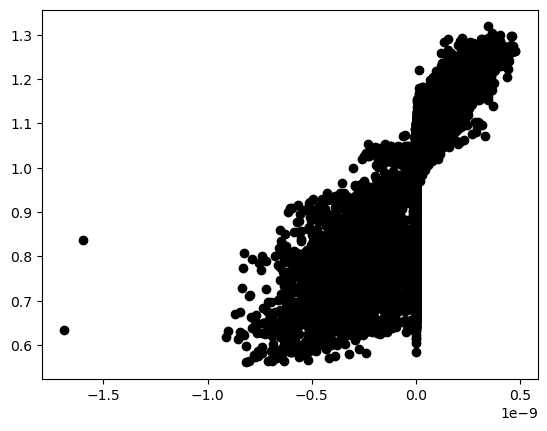

In [89]:
# plot mass growth vs. RH_ice relationship
df_train['mass_diff']=df_train['mass[kg]_2'] - df_train['mass[kg]_1']
plt.scatter(df_train['mass_diff'], df_train['RH_ice_1'], color="black")

Coefficients: 
 [[7.48105249e-10 9.88957221e-01]]
Mean squared error: 0.00
Coefficient of determination: 1.00


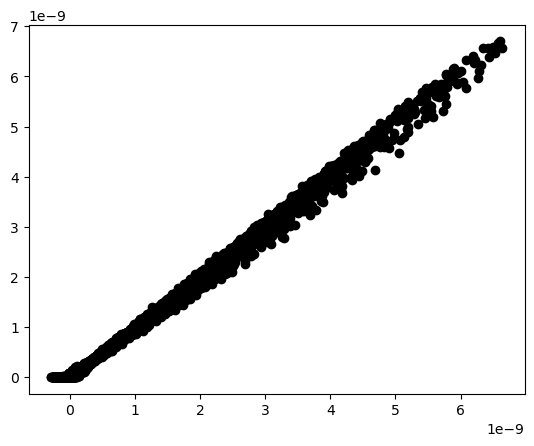

In [102]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(y_pred, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

## multi-step prediction with single-timestep linear model

i.e., what happens if we predict mass change in a markov chain fashion over multiple time steps into the future?

# Random forest

In [186]:
# get subset for faster training (if needed)
X_train_subset = X_train.sample(50000)
train_idx = X_train_subset.index
y_train_subset = y_train.loc[train_idx]
print(X_train_subset.shape)
print(y_train_subset.shape)

(50000, 2)
(50000, 1)


In [187]:
rf = RandomForestRegressor(n_estimators=100, random_state=666, max_depth=50, 
                           bootstrap=True, criterion='poisson')
# rf.fit(X_train, y_train.values.ravel())
rf.fit(X_train_subset, y_train_subset.values.ravel())
y_pred_rf = rf.predict(X_test)
len(np.unique(y_pred_rf))

50415

Coefficients: 
 [[7.48105249e-10 9.88957221e-01]]
Mean squared error: 0.00
Coefficient of determination: 0.14


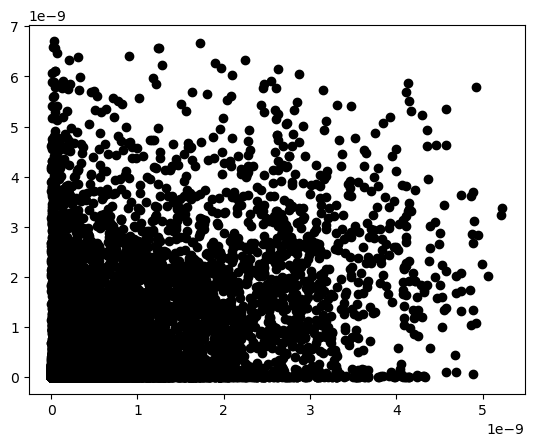

In [188]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rf))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_rf))

# Plot outputs
plt.scatter(y_pred_rf, y_test, color="black")
# plt.plot(X_test, y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

plt.show()

Notes on RF:  
- seems to be quite sensitive to hyperparameters
- squared_error and friendmas_mse returns a single value
- poisson and absolute_error return different values
- absolute_error is very slow
- seems to do much worse than linear regression

# scikit MLP

In [204]:
# # get subset for faster training (if needed)
# X_train_subset = X_train.sample(50000)
# train_idx = X_train_subset.index
# y_train_subset = y_train.loc[train_idx]
# print(X_train_subset.shape)
# print(y_train_subset.shape)

In [ ]:
# make mass_change the target


In [226]:
# fit mlp and predict
mlp = MLPRegressor(random_state=666, max_iter=500, 
                   hidden_layer_sizes=(100))
# mlp.fit(X_train, y_train.values.ravel())
# y_pred_mlp = mlp.predict(X_test)
y_scaler = StandardScaler().fit(y_train.values)
pipe = make_pipeline(StandardScaler(), mlp)
# pipe.fit(X_train, y_train.values.ravel())
pipe.fit(X_train, y_scaler.transform(y_train.values).ravel())
y_pred_mlp_scaled = pipe.predict(X_test)
y_pred_mlp = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1))

Coefficients: 
 [[7.48105249e-10 9.88957221e-01]]
Mean squared error: 0.00
Coefficient of determination: 1.00


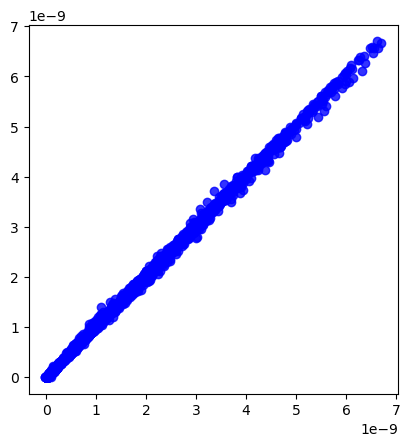

In [230]:
# plot results

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_mlp))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_mlp))

# Plot outputs
fig, ax = plt.subplots()
plt.scatter(y_pred_mlp, y_test, color="blue", alpha=0.8)
ax.set_box_aspect(1)
plt.show()